In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    average_precision_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve
)
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
import itertools
import optuna
from optuna.samplers import TPESampler

In [44]:
df_train = pd.read_csv('train_c.csv')
df_test = pd.read_csv('test_c.csv')

### Анализ датасета

In [45]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-null  float64
 12  NumberOfCreditInquiries     10487 non-null  float64
 13  DebtToIncomeRatio           104

In [46]:
df_train['LoanApproved'].value_counts()

LoanApproved
1.0    5367
0.0    5120
Name: count, dtype: int64

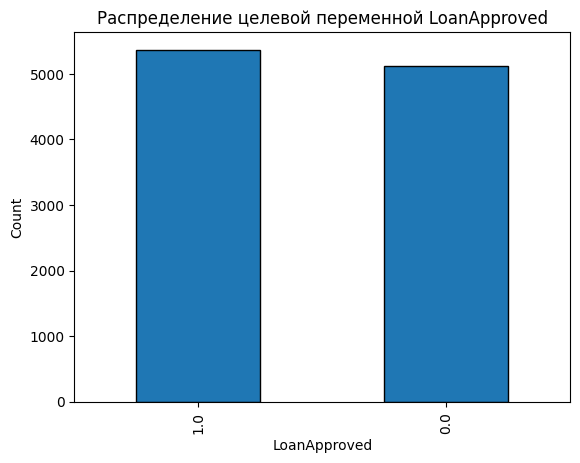

In [47]:
df_train['LoanApproved'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Распределение целевой переменной LoanApproved')
plt.xlabel('LoanApproved')
plt.ylabel('Count')
plt.show()

Посмотрим на баланс классов

In [48]:
print(f"Доля положительного класса: {df_train['LoanApproved'].mean():.4f}")
print(f"Доля отрицательного класса: {1 - df_train['LoanApproved'].mean():.4f}")

Доля положительного класса: 0.5118
Доля отрицательного класса: 0.4882


Удалим дату

In [49]:
df_train.drop(['ApplicationDate'], axis=1, inplace=True)
df_test.drop(['ApplicationDate'], axis=1, inplace=True)

Посмотрим на категориальные признаки

In [50]:
cat_features = df_train.select_dtypes(object).columns
for feature in cat_features:
  print(df_train[feature].value_counts(), end='\n-----\n-----\n')

MaritalStatus
Married     5145
Single      3217
Divorced    1562
Widowed      563
Name: count, dtype: int64
-----
-----
HomeOwnershipStatus
Mortgage    4148
Rent        3186
Own         2116
Other       1037
Name: count, dtype: int64
-----
-----
LoanPurpose
Home                  2981
Debt Consolidation    2446
Auto                  2010
Education             1601
Other                  948
Name: count, dtype: int64
-----
-----
EmploymentStatus
Employed         9059
Self-Employed     992
Unemployed        436
Name: count, dtype: int64
-----
-----
EducationLevel
High School    4234
Bachelor       3092
Associate      2057
Master          755
Doctorate       349
Name: count, dtype: int64
-----
-----


Построим распределение LoanApproved для категориальных признаков

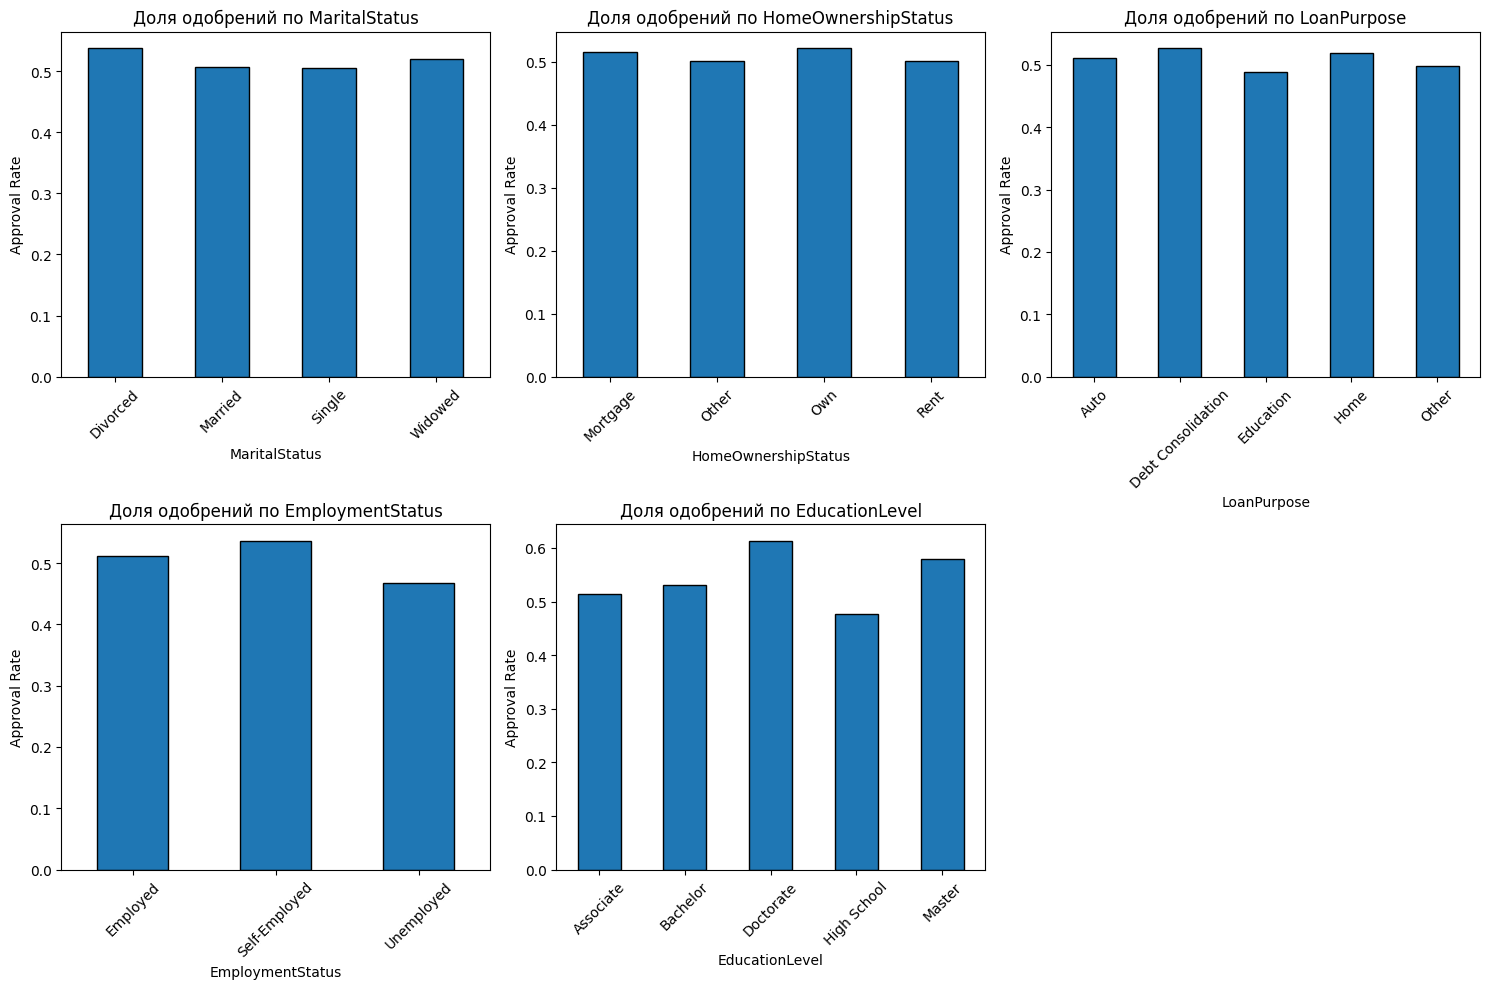

In [51]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(cat_features):
    df_train.groupby(feature)['LoanApproved'].mean().plot(kind='bar', ax=axes[idx], edgecolor='black')
    axes[idx].set_title(f'Доля одобрений по {feature}')
    axes[idx].set_ylabel('Approval Rate')
    axes[idx].tick_params(axis='x', rotation=45)

for idx in range(len(cat_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

Закодируем категориальные признаки и уберем пропуски

In [52]:
df_train = pd.get_dummies(df_train, drop_first=True)
df_test = pd.get_dummies(df_test, drop_first=True)
df_train.dropna(inplace=True)

Посмотрим на корреляции

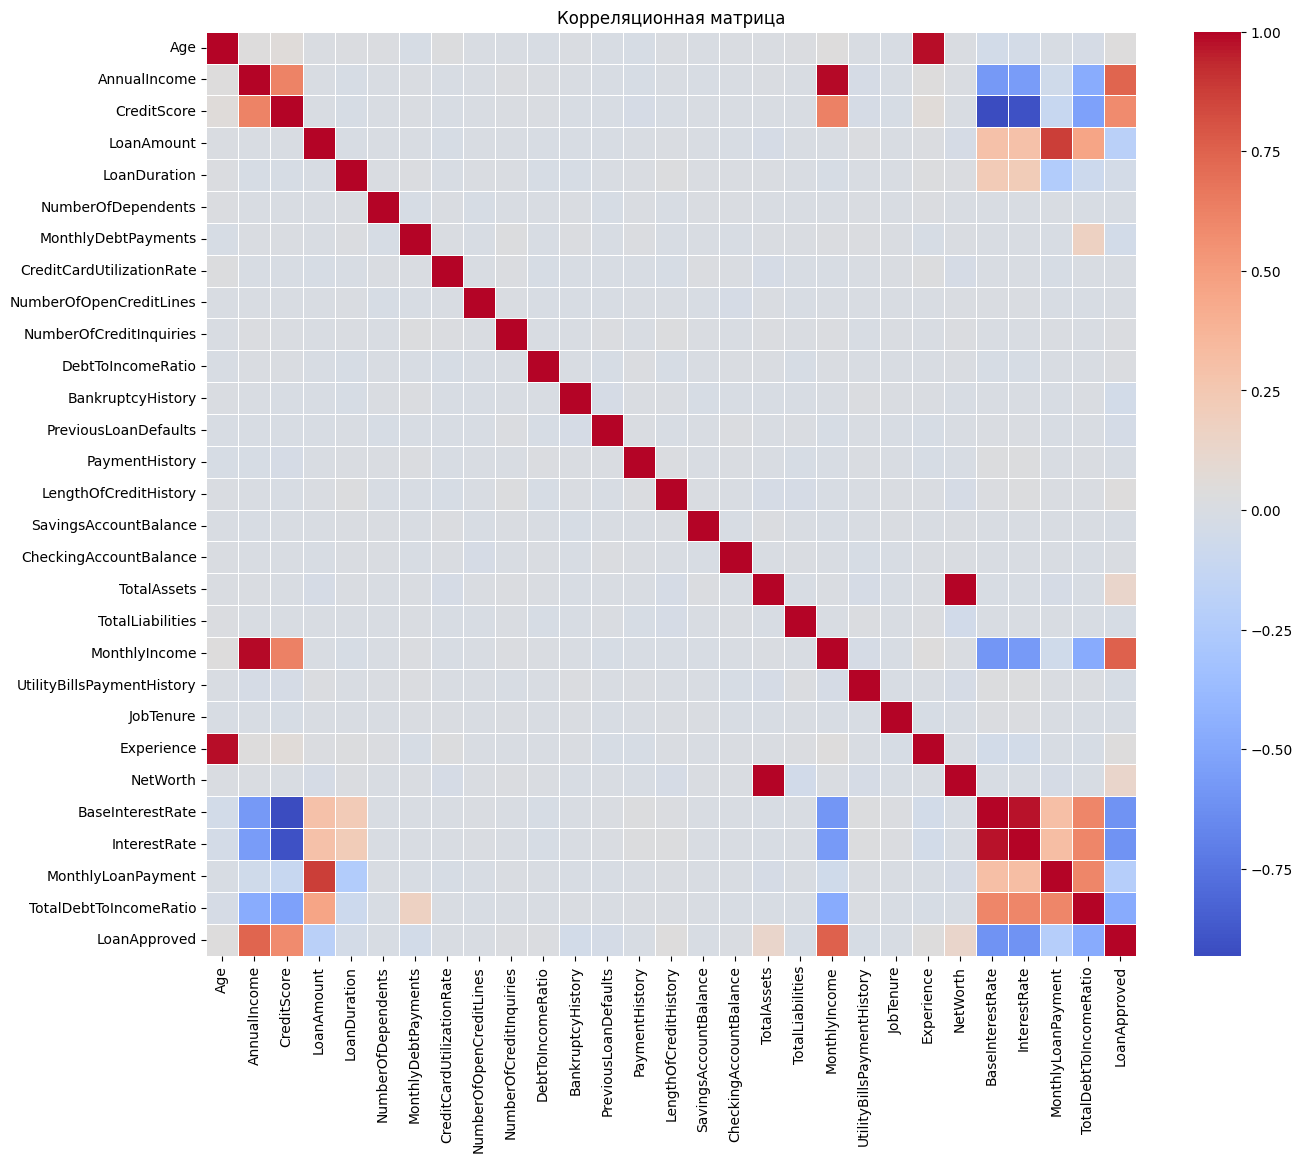

In [53]:
corr_matrix = df_train.select_dtypes(float).corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

In [54]:
correlations = df_train.corr()['LoanApproved'].abs().sort_values(ascending=False)
top_features = correlations.drop('LoanApproved').head(10)
print(top_features)

MonthlyIncome             0.754939
AnnualIncome              0.742706
BaseInterestRate          0.605164
InterestRate              0.600964
CreditScore               0.581812
TotalDebtToIncomeRatio    0.477925
MonthlyLoanPayment        0.217305
LoanAmount                0.195607
NetWorth                  0.129624
TotalAssets               0.129204
Name: LoanApproved, dtype: float64


In [55]:
corr_matrix = df_train.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_upper = corr_matrix.where(mask)

corr_pairs = corr_upper.unstack().reset_index()
corr_pairs.columns = ['feat1', 'feat2', 'correlation']

corr_pairs = corr_pairs.dropna()

corr_pairs = corr_pairs.reindex(
    corr_pairs['correlation'].abs().sort_values(ascending=False).index
)

print(corr_pairs.head(10))

                     feat1                  feat2  correlation
1052              NetWorth            TotalAssets     0.994042
856          MonthlyIncome           AnnualIncome     0.984910
990             Experience                    Age     0.982989
1149          InterestRate       BaseInterestRate     0.975359
1082      BaseInterestRate            CreditScore    -0.931766
1127          InterestRate            CreditScore    -0.907621
1173    MonthlyLoanPayment             LoanAmount     0.872539
1279          LoanApproved          MonthlyIncome     0.754939
1261          LoanApproved           AnnualIncome     0.742706
1379  MaritalStatus_Single  MaritalStatus_Married    -0.652299


Проанализируем фичи на наличие выбросов

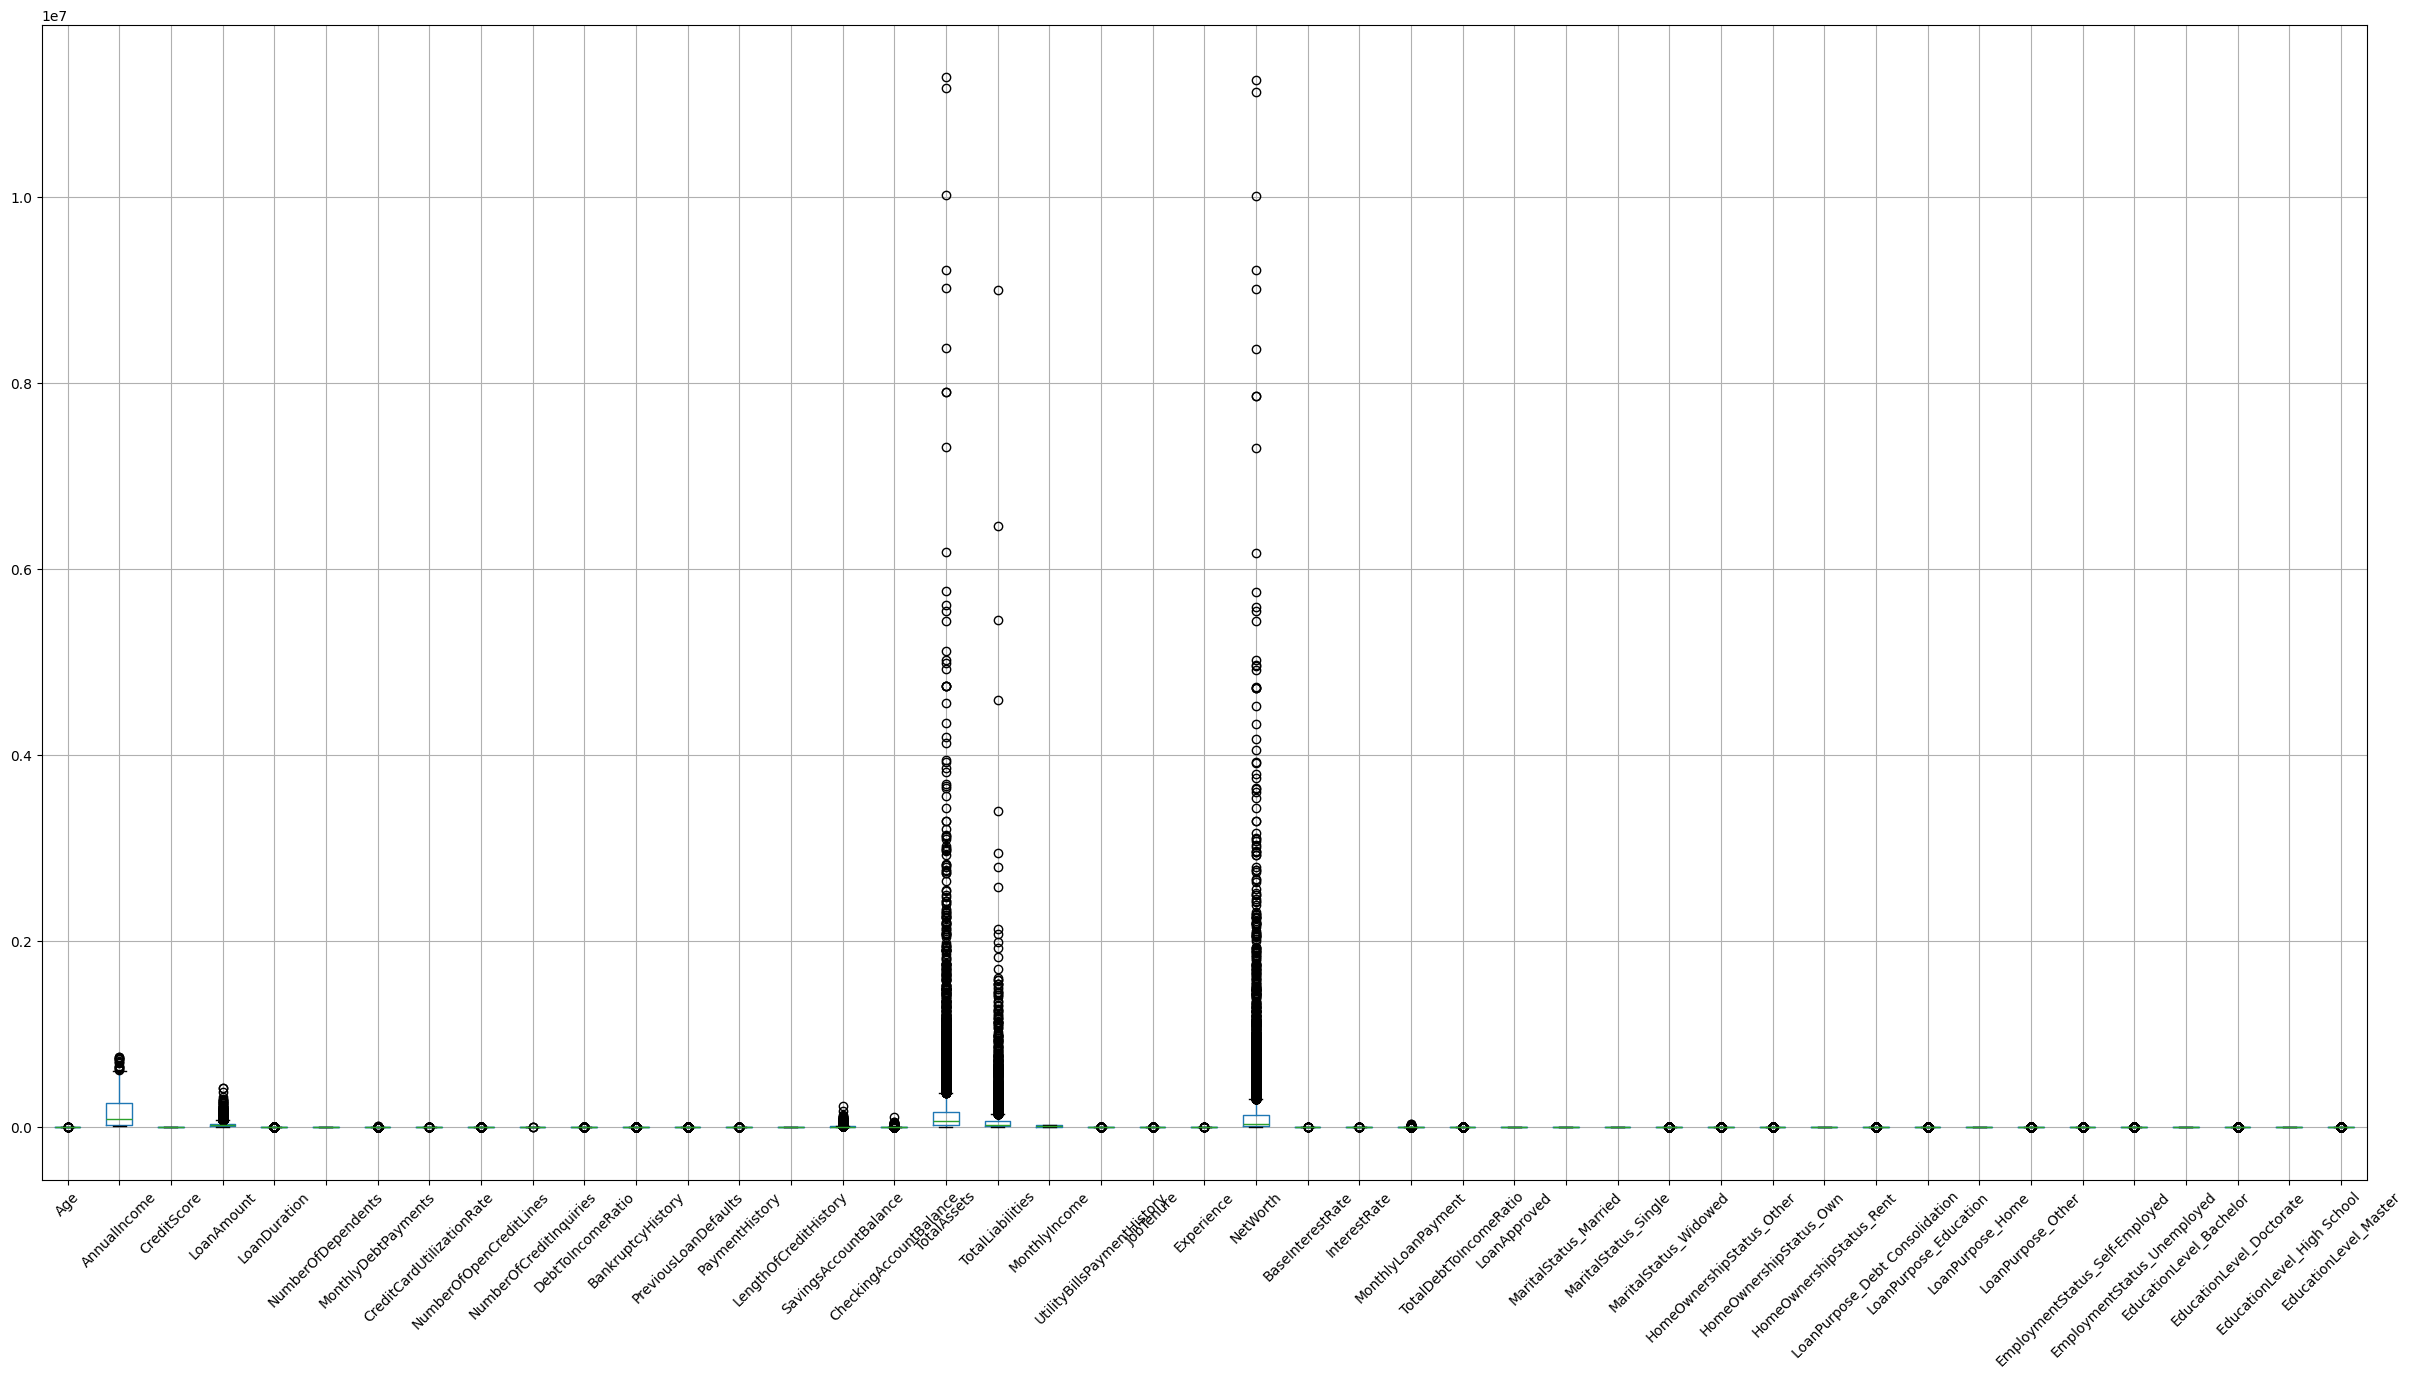

In [56]:
df_train.boxplot(figsize=(30, 15))
plt.xticks(rotation=45)
plt.show()

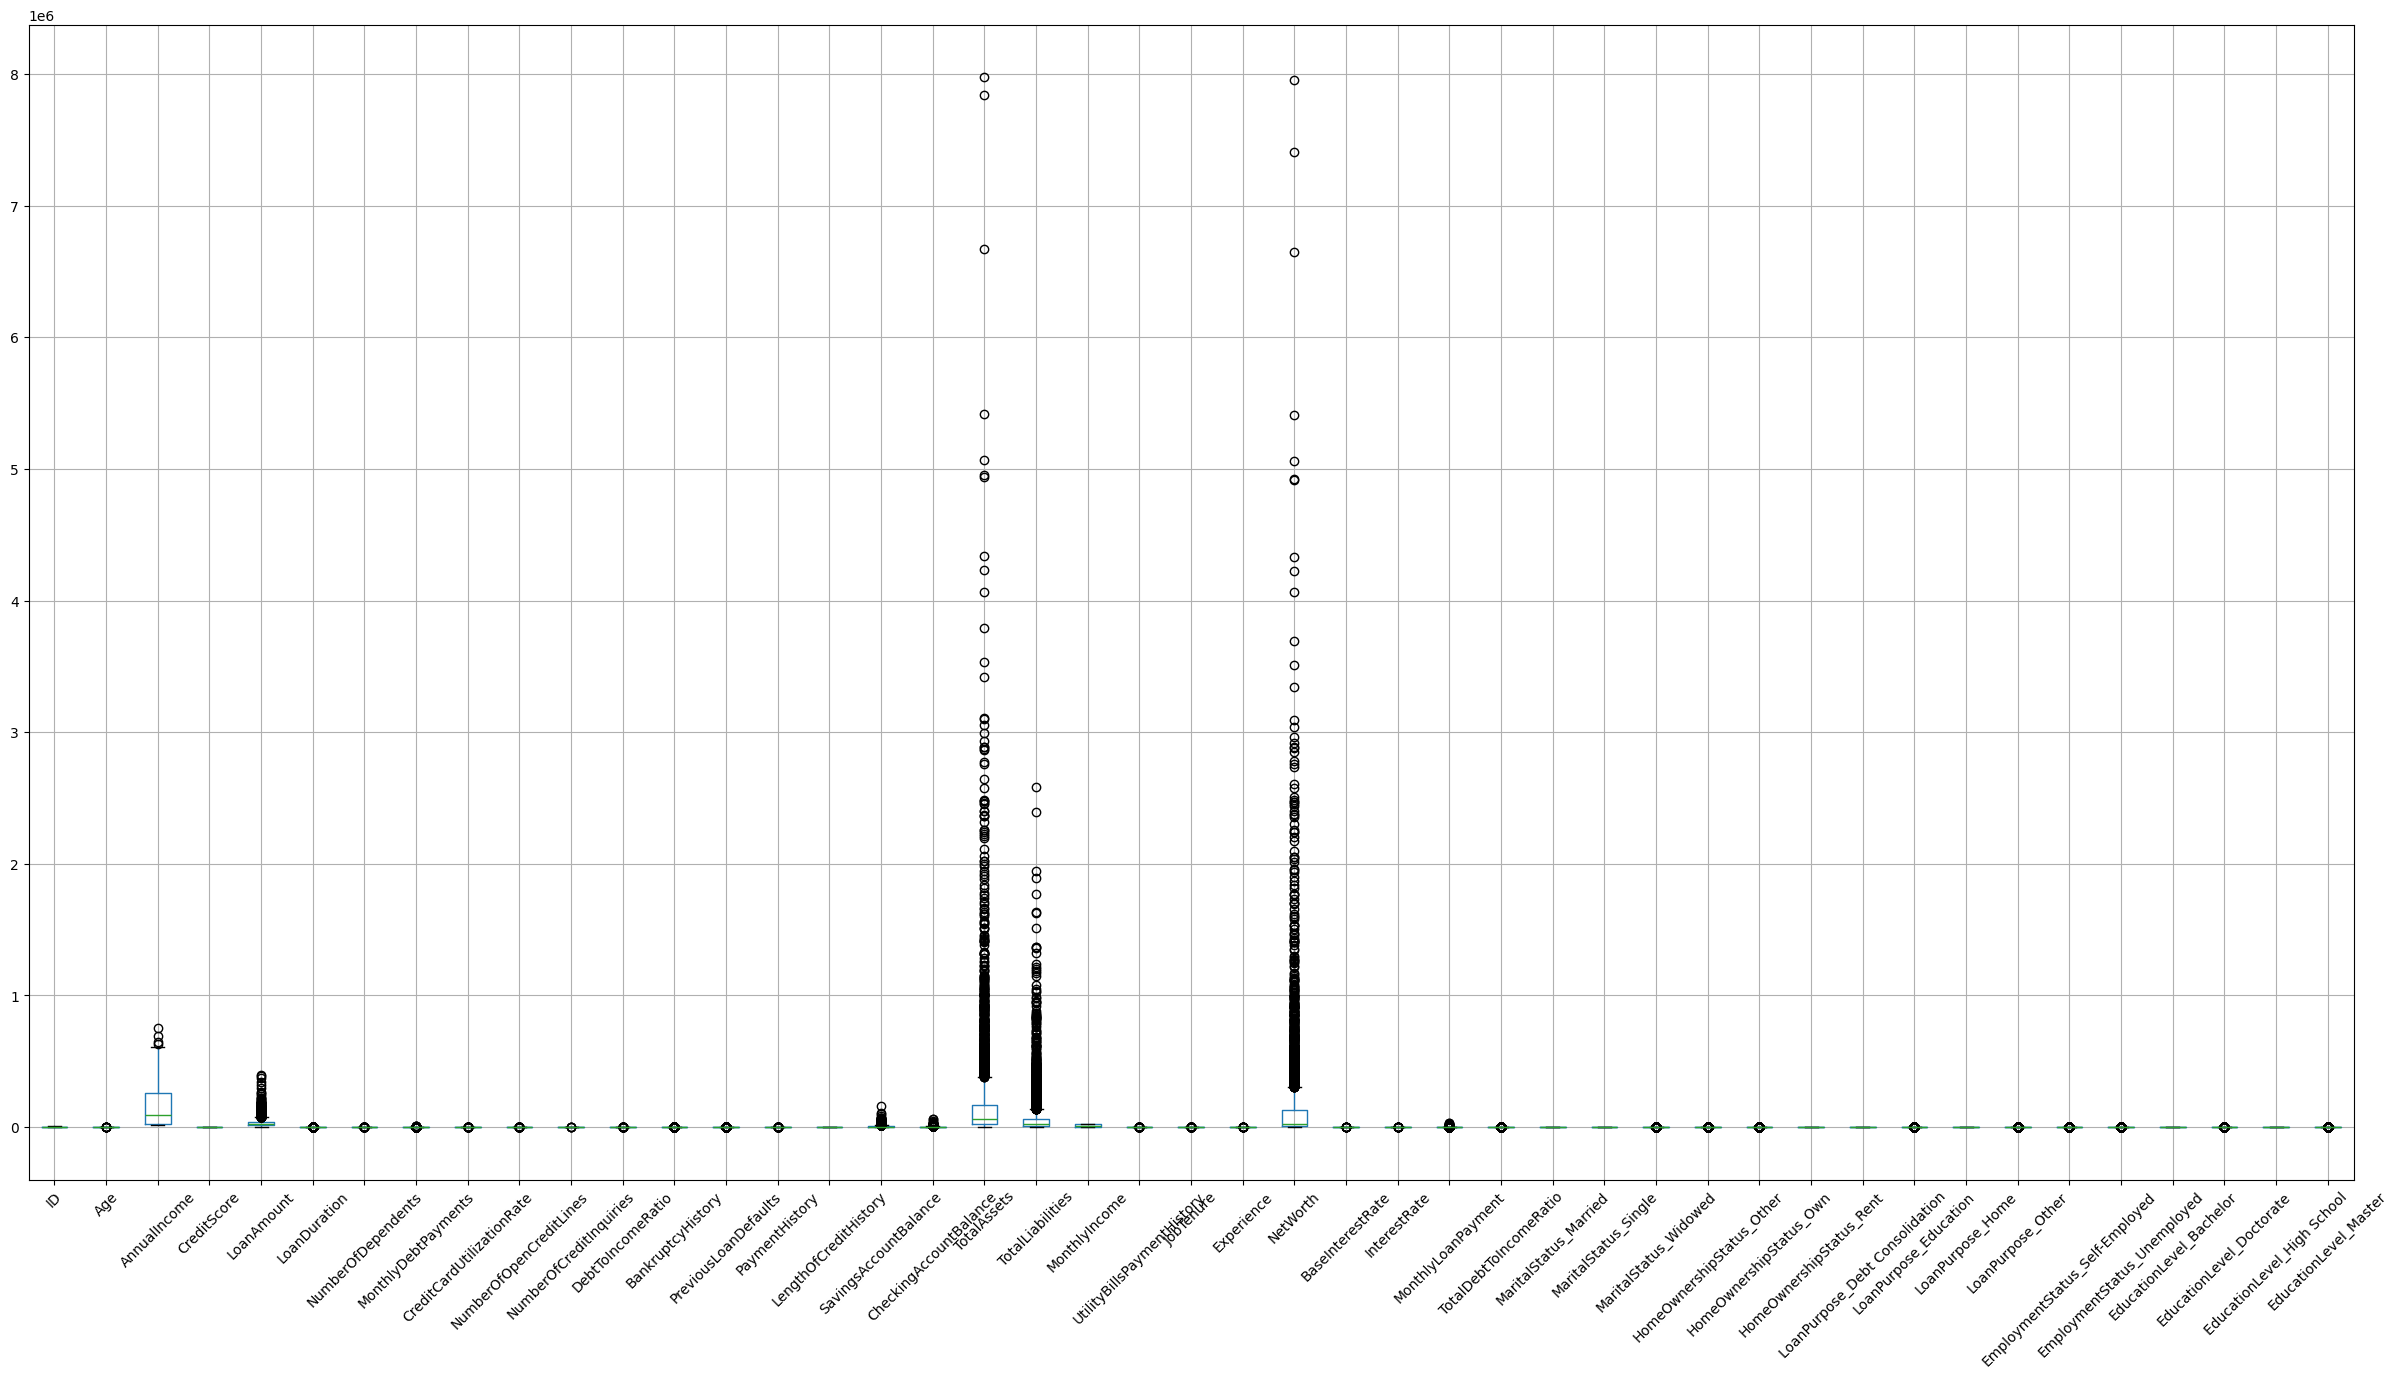

In [57]:
df_test.boxplot(figsize=(30, 15))
plt.xticks(rotation=45)
plt.show()

Посмотрим, как распределены фичи

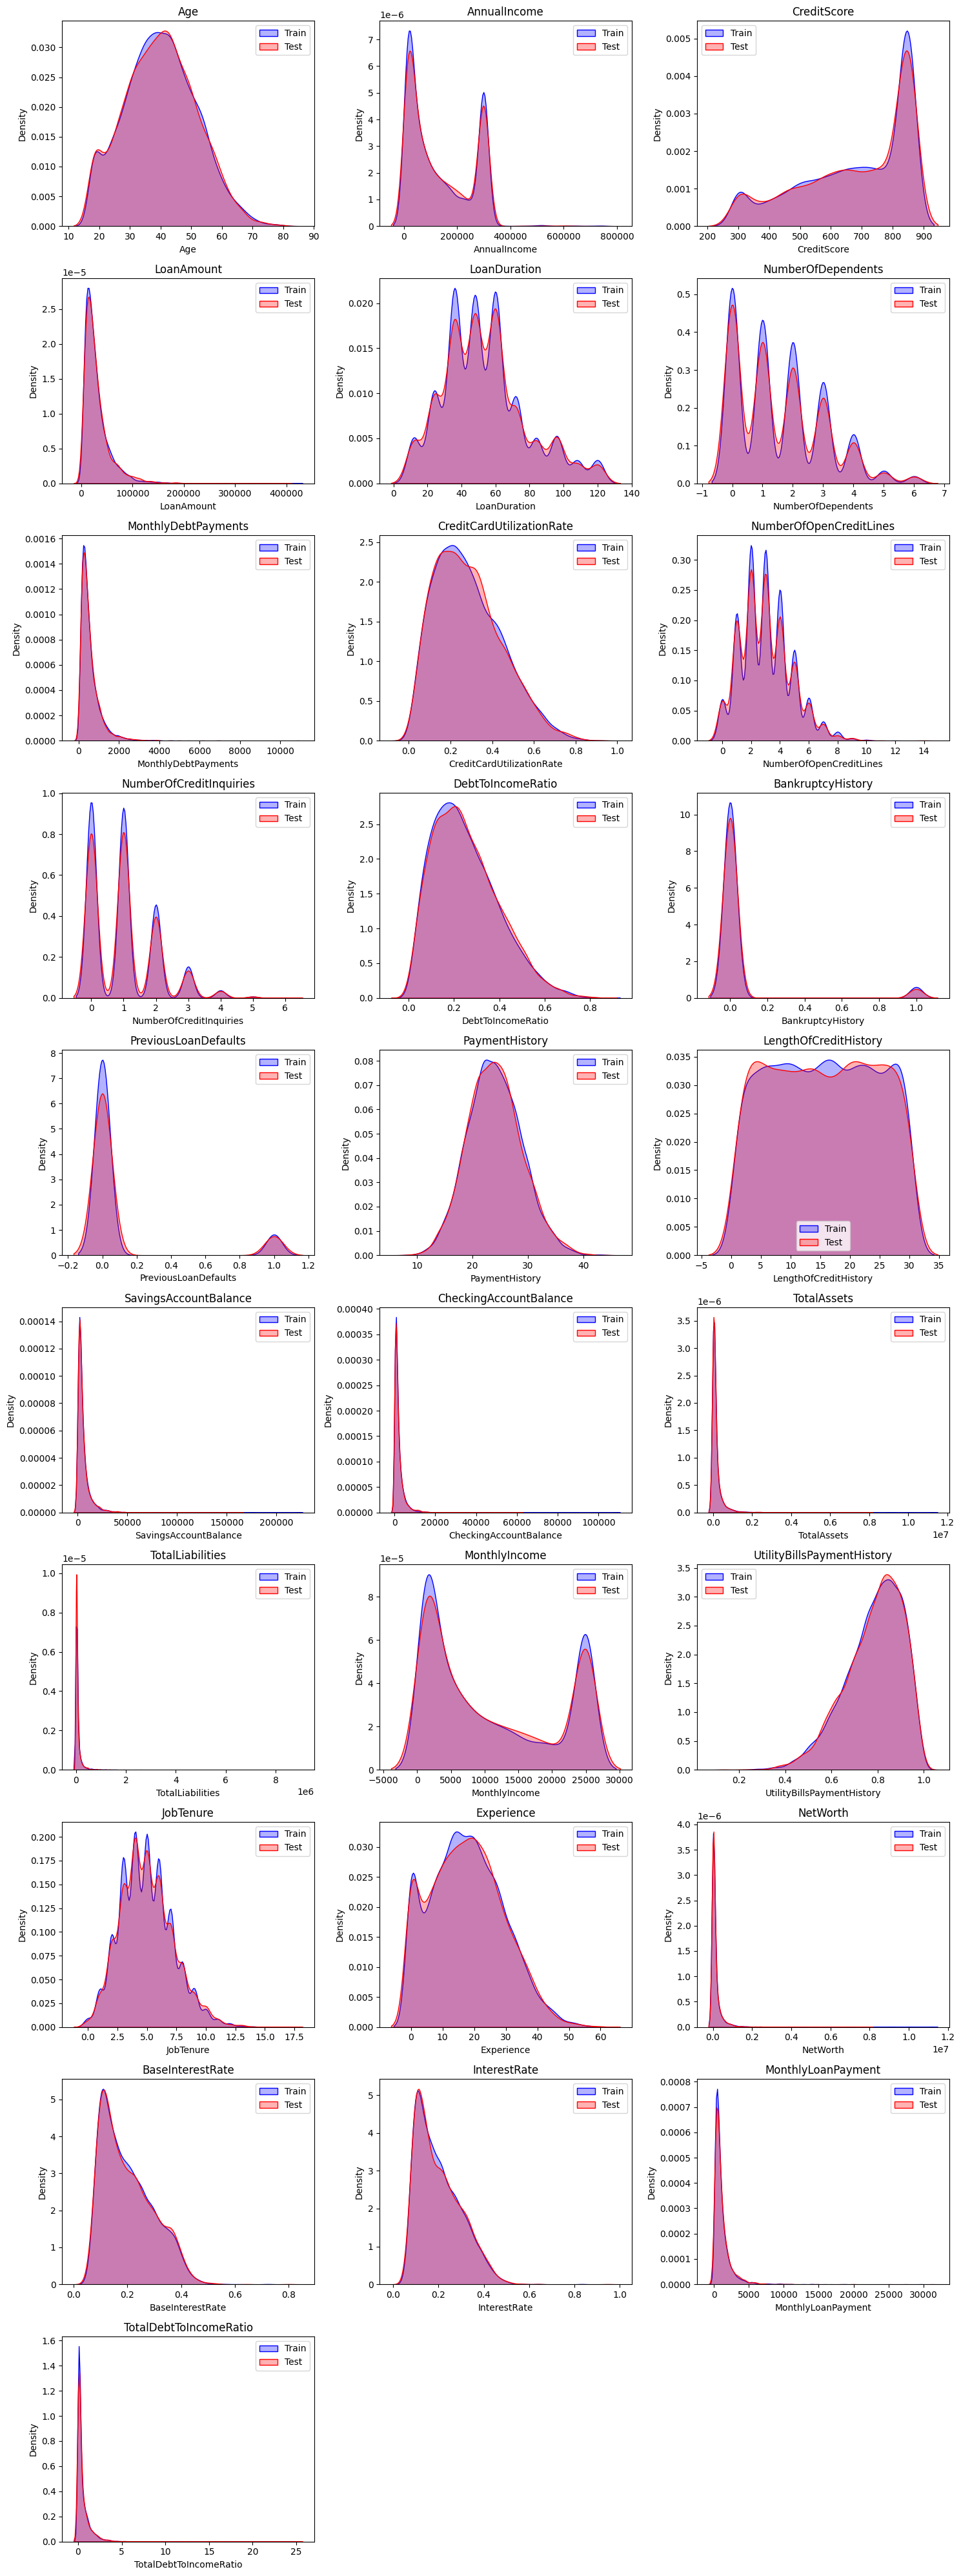

In [58]:
numeric_cols = df_train.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if col != 'LoanApproved']


n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    sns.kdeplot(df_train[col], label='Train', ax=axes[idx], 
                color='blue', fill=True, alpha=0.3)
    sns.kdeplot(df_test[col], label='Test', ax=axes[idx], 
                color='red', fill=True, alpha=0.3)
    
    axes[idx].set_title(f'{col}')
    axes[idx].legend()

for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

### Feature Engineering

In [59]:
features_sqrt = ['TotalDebtToIncomeRatio', 'CreditScore', 'NetWorth','MonthlyIncome']

for feature in features_sqrt:
    df_train[f'{feature}_sqrt'] = np.sqrt(df_train[feature])
    df_test[f'{feature}_sqrt'] = np.sqrt(df_test[feature])

In [60]:
features_cbrt = ['TotalDebtToIncomeRatio', 'CreditScore', 'NetWorth', 'MonthlyIncome']

for feature in features_cbrt:
    df_train[f'{feature}_cbrt'] = np.cbrt(df_train[feature])
    df_test[f'{feature}_cbrt'] = np.cbrt(df_test[feature])

In [61]:
features_log = ['AnnualIncome',
 'LoanAmount', 'NetWorth','TotalDebtToIncomeRatio', 'MonthlyLoanPayment', 'CreditScore', 'MonthlyIncome', 'BaseInterestRate'
]

for feature in features_log:
    df_train[f'{feature}_log'] = np.log1p(df_train[feature])
    df_test[f'{feature}_log'] = np.log1p(df_test[feature])

In [62]:
def add_interaction(feature1, feature2, operation):
    if operation == '*':
        df_train[f'{feature1}_multiplied_by_{feature2}'] = df_train[feature1] * df_train[feature2]

        df_test[f'{feature1}_multiplied_by_{feature2}'] = df_test[feature1] * df_test[feature2]
    elif operation == '/':
        df_train[f'{feature1}_divided_by_{feature2}'] = df_train[feature1] / df_train[feature2]

        df_test[f'{feature1}_divided_by_{feature2}'] = df_test[feature1] / df_test[feature2]

In [63]:
interactions = [
    ('MonthlyIncome', 'InterestRate', '*'),
    ('MonthlyIncome', 'InterestRate', '/'),
    ('MonthlyIncome', 'TotalDebtToIncomeRatio', '*'),
    ('MonthlyIncome', 'TotalDebtToIncomeRatio', '/'),

    ('MonthlyIncome', 'BaseInterestRate', '*'),
    ('MonthlyIncome', 'BaseInterestRate', '/'),
    ('MonthlyIncome', 'MonthlyLoanPayment', '*'),
    ('MonthlyIncome', 'MonthlyLoanPayment', '/'),
    ('MonthlyIncome', 'BankruptcyHistory', '*'),

    ('NetWorth_sqrt', 'BaseInterestRate', '*'),
    ('NetWorth_sqrt', 'BaseInterestRate', '/'),
    ('NetWorth_sqrt', 'TotalDebtToIncomeRatio', '*'),
    ('NetWorth_sqrt', 'TotalDebtToIncomeRatio', '/'),

    ('NetWorth_sqrt', 'BaseInterestRate', '*'),
    ('NetWorth_sqrt', 'MonthlyLoanPayment', '*'),
    ('NetWorth_sqrt', 'MonthlyLoanPayment', '/'),
    ('NetWorth_sqrt', 'BankruptcyHistory', '*'),

 
    ('MonthlyIncome', 'InterestRate', '/'),             # Доход на процент
    ('MonthlyIncome', 'BaseInterestRate', '/'),         # Доход на базовый %
    ('LoanAmount', 'BaseInterestRate', '/'),            # Размер на %
]

In [64]:
for pair in interactions:
    add_interaction(*pair)

In [65]:
polynomial_features = [
    'BaseInterestRate',
    'InterestRate',
    'TotalDebtToIncomeRatio',
    'DebtToIncomeRatio',
    'MonthlyLoanPayment',
    'CreditScore',
    'MonthlyIncome',
    'LengthOfCreditHistory',
]

In [66]:
new_cols_train = {}
new_cols_test = {}

for feature in polynomial_features:
    for power in [2, 3]:
        new_cols_train[f'{feature}_{power}'] = df_train[feature] ** power
        new_cols_test[f'{feature}_{power}'] = df_test[feature] ** power


df_train = pd.concat([df_train, pd.DataFrame(new_cols_train)], axis=1)
df_test = pd.concat([df_test, pd.DataFrame(new_cols_test)], axis=1)

In [67]:
y = df_train['LoanApproved']
df_train.drop(['LoanApproved'], axis=1, inplace=True)

### Тест моделей классификации: LogisticRegression, RidgeClassifier, SGDClassifier

In [68]:
import csv

def save_predict_to_file(model, test_df, output_path):
    test_features = test_df.drop('ID', axis=1)
    predictions = model.predict_proba(test_features)[:, 1]
    
    with open(output_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['ID', 'LoanApproved'])
        writer.writerows(zip(test_df['ID'], predictions))

In [69]:
def evaluate_classifier(y_true, y_pred_proba, y_pred, prefix=''):
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    pr_auc = average_precision_score(y_true, y_pred_proba)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"{prefix}ROC-AUC: {roc_auc:.6f}, PR-AUC: {pr_auc:.6f}, Precision: {precision:.6f}, Recall: {recall:.6f}, F1: {f1:.6f}")
    return roc_auc

In [70]:
models_config = [
    ('LogisticRegression', [LogisticRegression(C=c, max_iter=1000, random_state=42) 
                            for c in [0.001, 0.01, 0.1, 1.0, 10.0]]),
    ('RidgeClassifier', [RidgeClassifier(alpha=a, random_state=42) 
                         for a in [0.001, 0.01, 0.1, 1.0, 10.0]]),
    ('SGDClassifier', [SGDClassifier(loss='log_loss', alpha=a, max_iter=1000, random_state=42) 
                       for a in [0.0001, 0.001, 0.01, 0.1]]),
]

In [71]:
for model_name, models in models_config:
    print(f"\n{'='*50}\n{model_name}\n{'='*50}")
    
    for model in models:
        pipeline = make_pipeline(StandardScaler(), model)
        
        X_train, X_test, y_train, y_test = train_test_split(
            df_train, y, test_size=0.2, random_state=42
        )
        pipeline.fit(X_train, y_train)
        
        if hasattr(pipeline, 'predict_proba'):
            y_pred_proba_test = pipeline.predict_proba(X_test)[:, 1]
            y_pred_proba_train = pipeline.predict_proba(X_train)[:, 1]
        else:
            y_pred_proba_test = pipeline.decision_function(X_test)
            y_pred_proba_train = pipeline.decision_function(X_train)
        
        y_pred_test = pipeline.predict(X_test)
        y_pred_train = pipeline.predict(X_train)
        
        print(f"Model params: {model.get_params()}")
        evaluate_classifier(y_test, y_pred_proba_test, y_pred_test, prefix='Test  - ')
        evaluate_classifier(y_train, y_pred_proba_train, y_pred_train, prefix='Train - ')
        print('-----')


LogisticRegression
Model params: {'C': 0.001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Test  - ROC-AUC: 0.982098, PR-AUC: 0.984039, Precision: 0.934314, Recall: 0.921663, F1: 0.927945
Train - ROC-AUC: 0.981480, PR-AUC: 0.982979, Precision: 0.927022, Recall: 0.921117, F1: 0.924060
-----
Model params: {'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Test  - ROC-AUC: 0.986432, PR-AUC: 0.987754, Precision: 0.942439, Recall: 0.934236, F1: 0.938320
Train - ROC-AUC: 0.985690, PR-AUC: 0.986744, Precision: 0.936071, Recall: 0.932631, F1: 

### Оптимизация гиперпараметров с Optuna

In [72]:
X_train, X_val, y_train, y_val = train_test_split(
    df_train, y, test_size=0.2, random_state=42
)

In [73]:
def objective(trial):
    C = trial.suggest_float('C', 1e-4, 100.0, log=True)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
    
    if solver == 'saga':
        penalty = trial.suggest_categorical('penalty_saga', ['l1', 'l2', 'elasticnet'])
        if penalty == 'elasticnet':
            l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
        else:
            l1_ratio = None
    elif solver == 'liblinear':
        penalty = trial.suggest_categorical('penalty_liblinear', ['l1', 'l2'])
        l1_ratio = None
    else:
        penalty = 'l2'
        l1_ratio = None
    
    model = LogisticRegression(
        C=C,
        solver=solver,
        penalty=penalty,
        l1_ratio=l1_ratio,
        max_iter=5000,
        random_state=42
    )
    
    pipeline = make_pipeline(StandardScaler(), model)
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
    
    return scores.mean()

In [ ]:
sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=10, show_progress_bar=True)

[I 2025-12-10 23:42:49,635] A new study created in memory with name: no-name-a78c4e87-d639-4dab-91c6-d6a6fd269246


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-10 23:42:52,215] Trial 0 finished with value: 0.9850211879189856 and parameters: {'C': 0.017670169402947963, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.9850211879189856.
[I 2025-12-10 23:42:52,098] Trial 1 finished with value: 0.9795951345762475 and parameters: {'C': 0.0008632008168602544, 'solver': 'saga', 'penalty_saga': 'l2'}. Best is trial 0 with value: 0.9850211879189856.


In [ ]:
print(f"Best ROC-AUC: {study.best_value:.6f}")
print(f"Best params: {study.best_params}")

Best ROC-AUC: 0.986069
Best params: {'C': 0.35849855803404745, 'solver': 'liblinear', 'penalty_liblinear': 'l2'}


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

### Финальная модель с лучшими параметрами

In [ ]:
import warnings
warnings.filterwarnings('ignore')

best_params = study.best_params

solver = best_params['solver']
C = best_params['C']

if solver == 'saga':
    penalty = best_params.get('penalty_saga', 'l2')
    l1_ratio = best_params.get('l1_ratio', None)
elif solver == 'liblinear':
    penalty = best_params.get('penalty_liblinear', 'l2')
    l1_ratio = None
else:
    penalty = 'l2'
    l1_ratio = None

final_model = LogisticRegression(
    C=C,
    solver=solver,
    penalty=penalty,
    l1_ratio=l1_ratio,
    max_iter=5000,
    random_state=42
)

final_pipeline = make_pipeline(StandardScaler(), final_model)
final_pipeline.fit(df_train, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.35849855803404745, max_iter=5000,
                                    random_state=42, solver='liblinear'))])

In [ ]:
y_pred_proba = final_pipeline.predict_proba(df_train)[:, 1]
y_pred = final_pipeline.predict(df_train)

print("Метрики на полном тренировочном наборе:")
evaluate_classifier(y, y_pred_proba, y_pred)

Метрики на полном тренировочном наборе:
ROC-AUC: 0.987799, PR-AUC: 0.988784, Precision: 0.940345, Recall: 0.936669, F1: 0.938504


np.float64(0.9877987567288997)

### Визуализация результатов

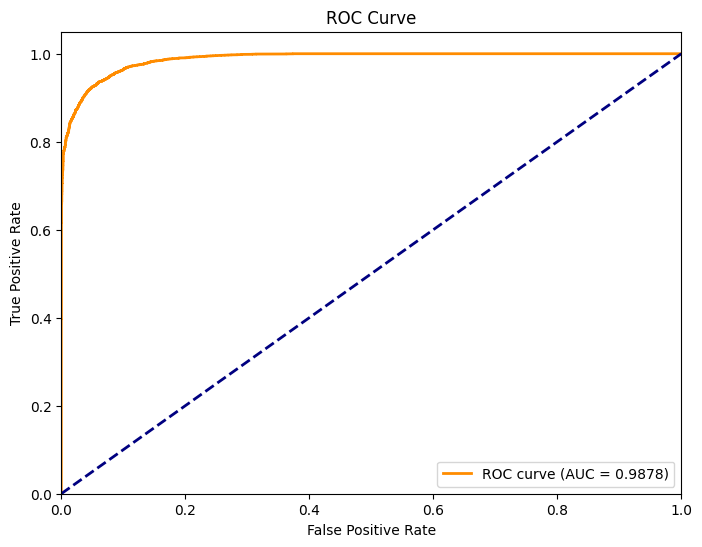

In [ ]:
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
roc_auc = roc_auc_score(y, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

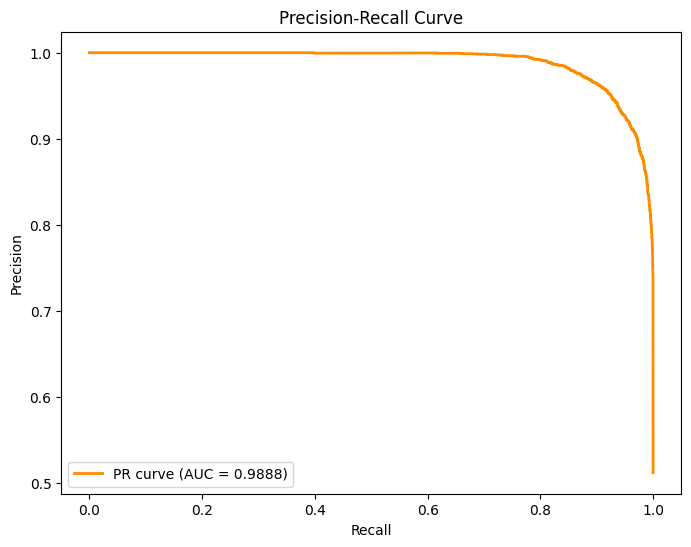

In [ ]:
precision_curve, recall_curve, _ = precision_recall_curve(y, y_pred_proba)
pr_auc = average_precision_score(y, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, color='darkorange', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

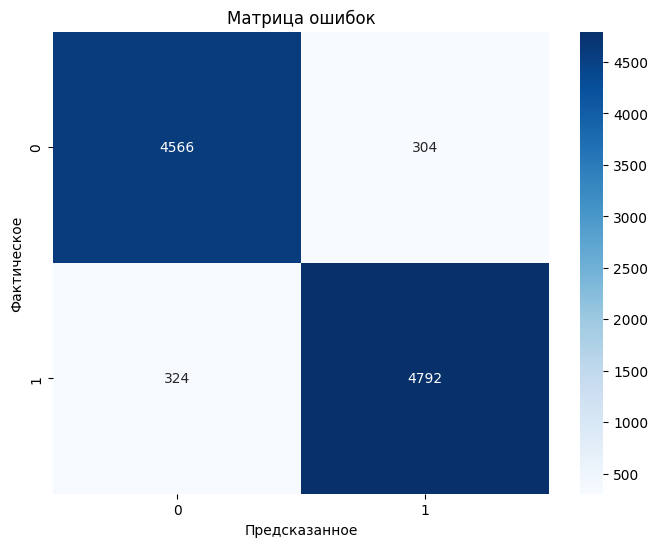

In [ ]:
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанное')
plt.ylabel('Фактическое')
plt.title('Матрица ошибок')
plt.show()

In [ ]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94      4870
         1.0       0.94      0.94      0.94      5116

    accuracy                           0.94      9986
   macro avg       0.94      0.94      0.94      9986
weighted avg       0.94      0.94      0.94      9986



### Сохранение предсказаний

In [ ]:
save_predict_to_file(final_pipeline, df_test, 'submission_c.csv')